In [1]:
import numpy as np
import pandas as pd 
import torch 
import matplotlib.pyplot as plt 

In [2]:
import os 
os.chdir('/kaggle/input/diffdata') 

In [3]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np

class SuperresDataset(Dataset):
    def __init__(self, hr_images, lr_images, max_images=None):
        """
        Initialize the SuperresDataset.
        Parameters:
        - hr_images (numpy array): High-resolution images of shape (N, 1, 128, 128).
        - lr_images (numpy array): Low-resolution images of shape (N, 1, 64, 64).
        - max_images (int, optional): Maximum number of images to use.
        """
        self.hr_images = torch.from_numpy(self.normalize(hr_images))
        self.lr_images = torch.from_numpy(self.normalize(lr_images))
        
        if max_images is not None:
            self.hr_images = self.hr_images[:max_images]
            self.lr_images = self.lr_images[:max_images]
        
    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        """
        Get the interpolated low-resolution image and high-resolution image at the specified index.
        Parameters:
        - idx (int): Index of the image to retrieve.
        Returns:
        - tuple of torch.Tensor: Interpolated low-resolution image and high-resolution image.
        """
        hr = self.hr_images[idx]
        lr = self.lr_images[idx]
        
        # Interpolate LR image to the size of HR image
        lr_interpolated = F.interpolate(lr.unsqueeze(0), size=(128, 128), mode='bilinear', align_corners=False)
        
        return lr_interpolated.squeeze(0), hr

    @staticmethod
    def normalize(x):
        """
        Normalize the images to [0, 1] range.
        """
        return (x - np.min(x)) / (np.max(x) - np.min(x))

In [4]:
hr_images = np.load('HR_new.npy')
lr_images = np.load('LR_new.npy')

In [5]:
import numpy as np
import torch
from torch.utils.data import DataLoader

total_samples = len(hr_images)
train_size = int(0.90 * total_samples)
test_size = total_samples - train_size
indices = np.arange(total_samples)
np.random.shuffle(indices)
train_indices, test_indices = indices[:train_size], indices[train_size:]

train_dataset = SuperresDataset([hr_images[i] for i in train_indices], [lr_images[i] for i in train_indices])
test_dataset = SuperresDataset([hr_images[i] for i in test_indices], [lr_images[i] for i in test_indices])

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
dataiter = iter(train_loader)
batch = next(dataiter)

hr_images = batch[1]
min_val = hr_images.min().item()
max_val = hr_images.max().item()

print(f"Min value: {min_val}, Max value: {max_val}")

Min value: 0.043350715190172195, Max value: 0.9262616634368896


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE_UNet(nn.Module):
    def __init__(self, dim=128, dim_mults=(1, 2, 4, 8), channels=1, latent_dim=256):
        super().__init__()
        self.channels = channels
        self.latent_dim = latent_dim
        dims = [channels, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        # Encoder (downsampling path)
        self.encoder = nn.ModuleList([])
        for dim_in, dim_out in in_out:
            self.encoder.append(nn.ModuleList([
                nn.Conv2d(dim_in, dim_out, 3, stride=2 if dim_in != channels else 1, padding=1),
                nn.InstanceNorm2d(dim_out),
                nn.LeakyReLU(0.2),
                ResnetBlock(dim_out, dim_out),
            ]))

        # Latent space
        self.fc_mu = nn.Linear(dims[-1] * 16 * 16, latent_dim)
        self.fc_var = nn.Linear(dims[-1] * 16 * 16, latent_dim)

        # Decoder (upsampling path)
        self.decoder_input = nn.Linear(latent_dim, dims[-1] * 16 * 16)
        self.decoder = nn.ModuleList([])
        for dim_out, dim_in in reversed(in_out[1:]):
            self.decoder.append(nn.ModuleList([
                nn.ConvTranspose2d(dim_in, dim_out, 4, stride=2, padding=1),
                nn.InstanceNorm2d(dim_out),
                nn.LeakyReLU(0.2),
                ResnetBlock(dim_out, dim_out),
            ]))

        # Final layer
        self.final_conv = nn.Conv2d(dims[1], channels, 3, padding=1)

    def encode(self, x):
        for conv, norm, act, resnet in self.encoder:
            x = conv(x)
            x = norm(x)
            x = act(x)
            x = resnet(x)
        
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(x.size(0), -1, 16, 16)
        for conv_transpose, norm, act, resnet in self.decoder:
            x = conv_transpose(x)
            x = norm(x)
            x = act(x)
            x = resnet(x)
        return self.final_conv(x)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

class ResnetBlock(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, 3, padding=1),
            nn.InstanceNorm2d(dim_out),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return x + self.block(x)

def vae_loss(recon_x, x, mu, log_var, kld_weight=0.00025):
    batch_size = x.size(0)
    num_pixels = x.size(1) * x.size(2) * x.size(3)  # channels * height * width
    
    MSE = F.mse_loss(recon_x, x, reduction='sum') / (batch_size)
    
    # KL divergence loss, normalized by batch size and latent dimension
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / (batch_size)
    
    # Total loss
    total_loss = MSE + kld_weight * KLD
    
    return total_loss, MSE, KLD

In [14]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

def plot_results(model, lr, hr, device, epoch, save_dir):
    model.eval()
    with torch.no_grad():
        recon_hr, _, _ = model(lr.to(device))
    
    # Convert tensors to numpy arrays and move to CPU
    lr = lr.cpu().numpy()
    hr = hr.cpu().numpy()
    recon_hr = recon_hr.cpu().numpy()
    
    # Plot the results
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    for i in range(4):
        axes[0, i].imshow(lr[i, 0], cmap='gray')
        axes[0, i].set_title(f'Low Res {i+1}')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(hr[i, 0], cmap='gray')
        axes[1, i].set_title(f'High Res {i+1}')
        axes[1, i].axis('off')
        
        axes[2, i].imshow(recon_hr[i, 0], cmap='gray')
        axes[2, i].set_title(f'Reconstructed {i+1}')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'epoch_{epoch+1}_results.png'))
    plt.close()

def train_vae(model, train_loader, optimizer, device, save_dir='/kaggle/working/', epochs=50, clip_value=1.0, plot_every=5):
    best_loss = float('inf')
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        max_grad = 0
        
        print(f"Epoch {epoch+1}/{epochs}")
        progress_bar = tqdm(train_loader, desc=f"Training", leave=True)
        
        for batch in progress_bar:
            optimizer.zero_grad()
            
            lr, hr = batch
            lr = lr.to(device)
            hr = hr.to(device)
            
            # Forward pass
            recon_hr, mu, log_var = model(lr)
            
            # Compute loss
            loss, mse, kld = vae_loss(recon_hr, hr, mu, log_var)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)
            
            # Monitor gradients
            for param in model.parameters():
                if param.grad is not None:
                    max_grad = max(max_grad, param.grad.data.abs().max().item())
            
            optimizer.step()
            
            total_loss += loss.item()
            
            # Update progress bar
            progress_bar.set_postfix({
                "Loss": f"{loss.item():.4f}",
                "MSE": f"{mse.item():.4f}",
                "KLD": f"{kld.item():.4f}",
                "Max Grad": f"{max_grad:.4f}"
            })
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}, Max Gradient: {max_grad:.4f}")
        
        # Adjust learning rate
        scheduler.step(avg_loss)
        
        # Save the best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_path = os.path.join(save_dir, 'best_vae_model.pth')
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with loss: {best_loss:.4f}")
        
        # Plot results every plot_every epochs
        if (epoch + 1) % plot_every == 0:
            lr_sample, hr_sample = next(iter(train_loader))
            plot_results(model, lr_sample[:4].to(device), hr_sample[:4].to(device), device, epoch, save_dir)
            print(f"Results plotted for epoch {epoch+1}")
        
        print(f"Current learning rate: {optimizer.param_groups[0]['lr']:.6f}")
        print()
    
    print("Training completed!")
    print(f"Best model saved with loss: {best_loss:.4f}")

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
model = VAE_UNet(dim=128, dim_mults=(1, 2, 4, 8), channels=1, latent_dim=256)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

model = model.to(device)

Using 2 GPUs!


In [ ]:
from torch import optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_vae(model, train_loader, optimizer, device, epochs=20)

Epoch 1/20


Training: 100%|██████████| 638/638 [03:42<00:00,  2.87it/s, Loss=35.7423, MSE=34.3324, KLD=5639.6143, Max Grad=0.1024]       


Epoch 1/20, Average Loss: 163.3422, Max Gradient: 0.1024
New best model saved with loss: 163.3422
Current learning rate: 0.000100

Epoch 2/20


Training: 100%|██████████| 638/638 [03:43<00:00,  2.86it/s, Loss=21.0009, MSE=18.1335, KLD=11469.4414, Max Grad=0.1054]           


Epoch 2/20, Average Loss: 14262.8518, Max Gradient: 0.1054
Current learning rate: 0.000100

Epoch 3/20


Training: 100%|██████████| 638/638 [03:42<00:00,  2.86it/s, Loss=38.7232, MSE=33.5909, KLD=20529.3027, Max Grad=0.0986]                


Epoch 3/20, Average Loss: 11764289.4592, Max Gradient: 0.0986
Current learning rate: 0.000100

Epoch 4/20


Training: 100%|██████████| 638/638 [03:42<00:00,  2.86it/s, Loss=22.2725, MSE=19.0768, KLD=12782.4238, Max Grad=0.1156]                     


Epoch 4/20, Average Loss: 581615235.0787, Max Gradient: 0.1156
Current learning rate: 0.000100

Epoch 5/20


Training:  81%|████████  | 514/638 [02:59<00:43,  2.87it/s, Loss=29.7563, MSE=23.7788, KLD=23910.1211, Max Grad=0.1074]          

In [ ]:
from torch import optim
optimizer = optim.Adam(model.parameters(), lr=1e-5)
train_vae(model, train_loader, optimizer, device, epochs=20)

In [ ]:
from torch import optim
optimizer = optim.Adam(model.parameters(), lr=1e-6)
train_vae(model, train_loader, optimizer, device, epochs=20)

In [ ]:
from torch import optim
optimizer = optim.Adam(model.parameters(), lr=1e-6)
train_vae(model, train_loader, optimizer, device, epochs=20)

In [31]:
save_path = "/kaggle/working/vae.pth"
torch.save(model.state_dict(), save_path)
print("Saved Successfully")

Saved Successfully


Evaluating: 100%|██████████| 71/71 [00:09<00:00,  7.73it/s]


Average PSNR: 26.00 ± 2.59
Average SSIM: 0.5944 ± 0.1424
Average MSE: 0.002520 ± 0.001707
Average L1 Loss: 0.043992 ± 0.014984


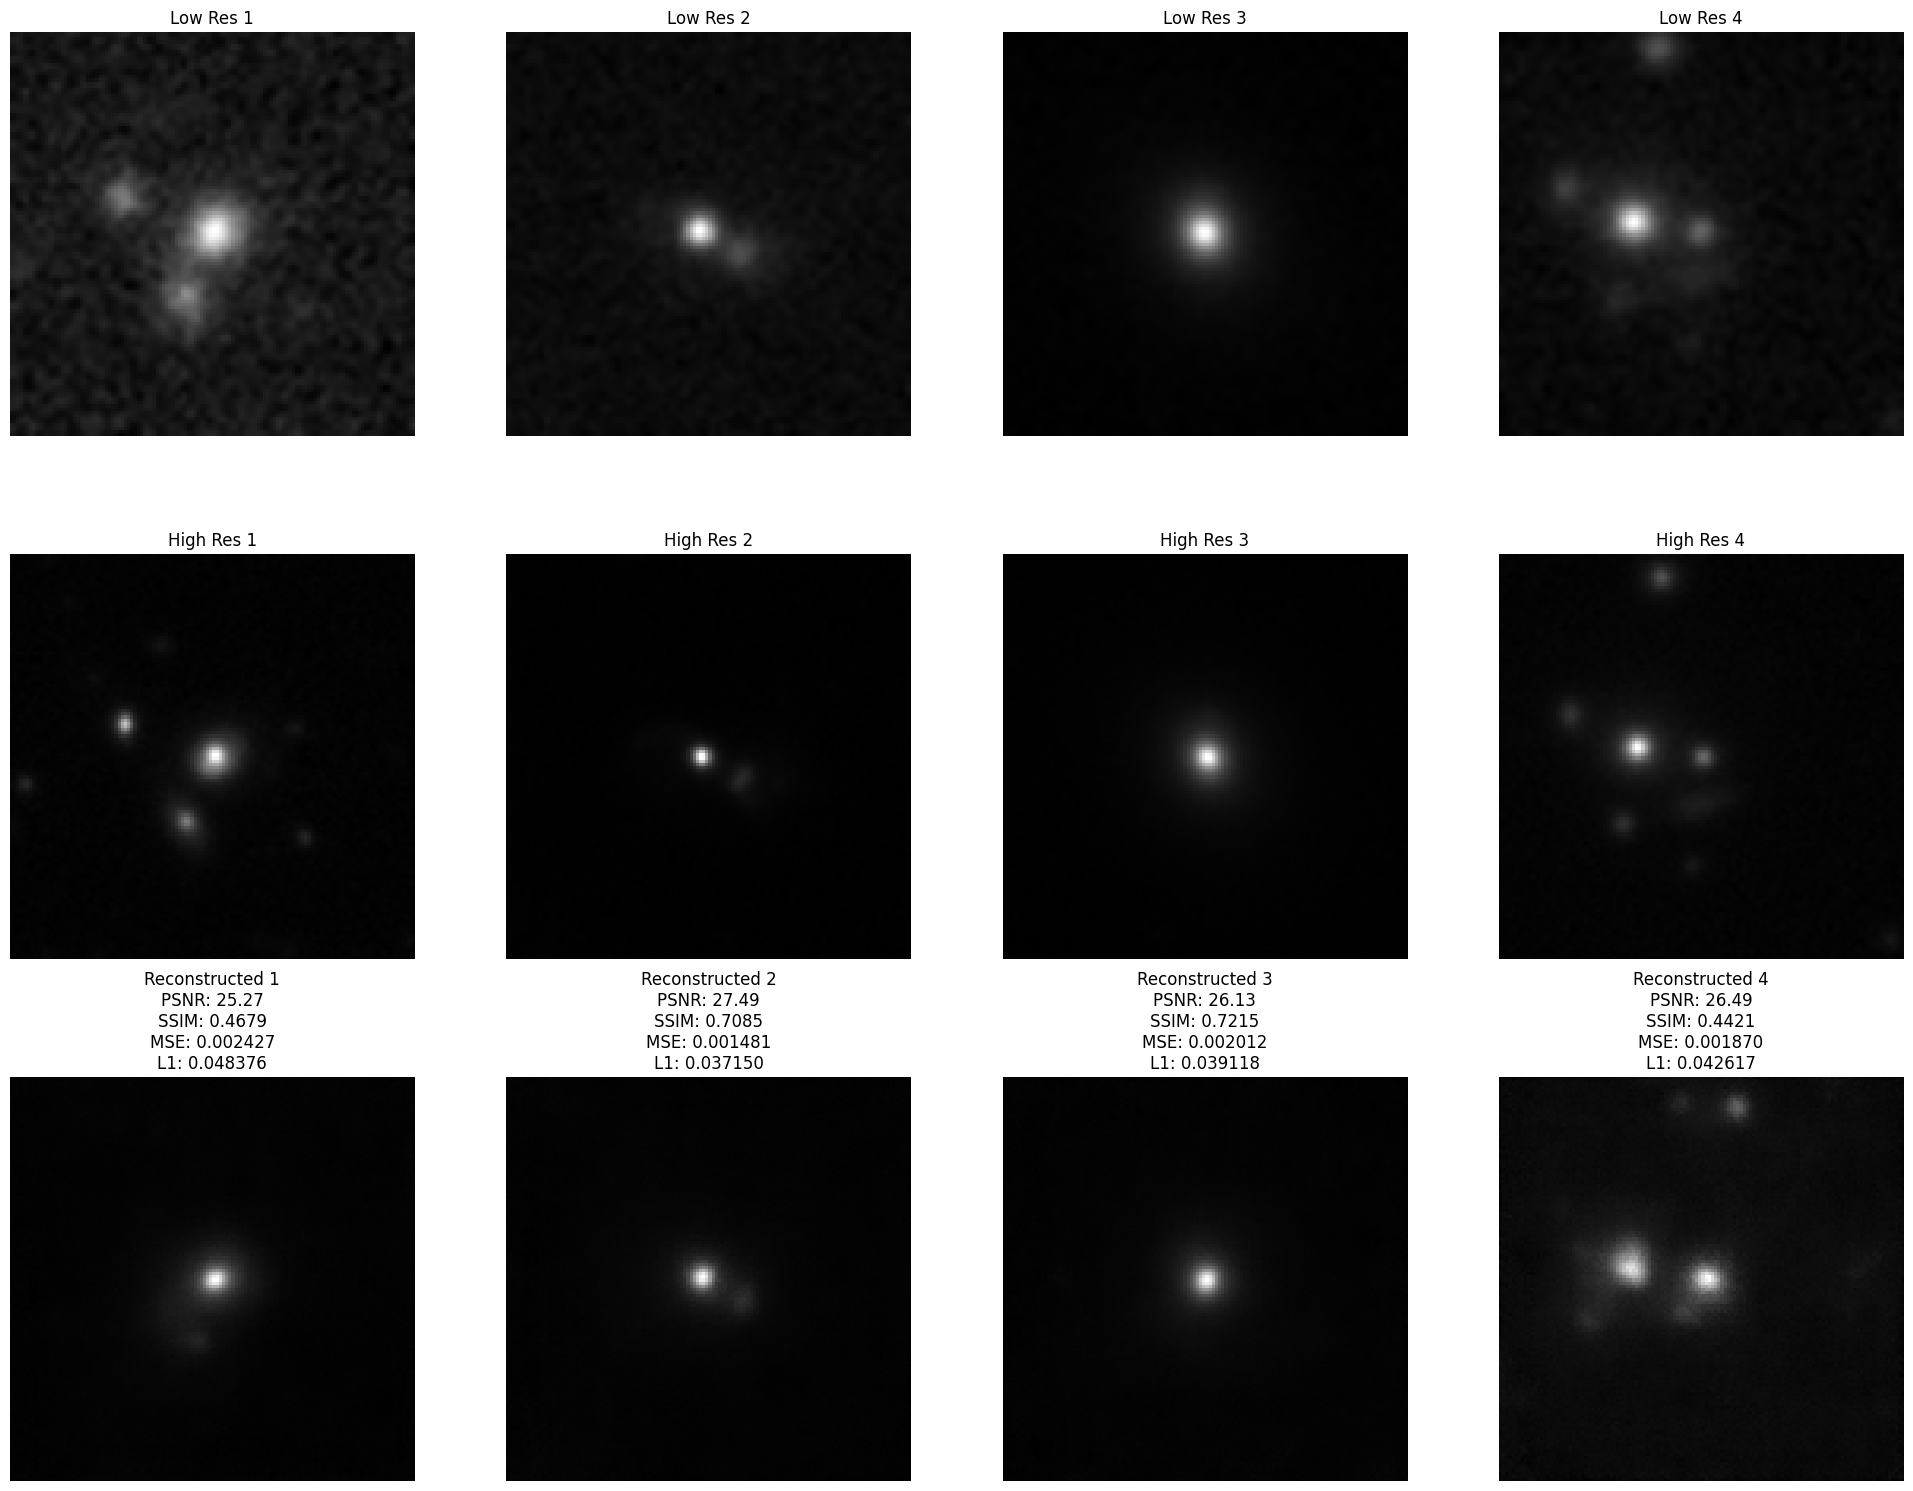

In [27]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tqdm import tqdm

def calculate_psnr(img1, img2):
    return psnr(img1, img2, data_range=img1.max() - img1.min())

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=img1.max() - img1.min())

def evaluate_vae(model, test_loader, device):
    model.eval()
    
    psnr_values = []
    ssim_values = []
    mse_values = []
    l1_values = []
    
    with torch.no_grad():
        for lr_test, hr_test in tqdm(test_loader, desc="Evaluating"):
            lr_test = lr_test.to(device)
            hr_test = hr_test.to(device)
            
            recon_hr, _, _ = model(lr_test)
      
            hr_test = hr_test.cpu().numpy()
            recon_hr = recon_hr.cpu().numpy()
            
            for i in range(hr_test.shape[0]):
                hr = hr_test[i, 0]
                sr = recon_hr[i, 0]
                
                psnr_values.append(calculate_psnr(hr, sr))
                ssim_values.append(calculate_ssim(hr, sr))
                mse_values.append(np.mean((hr - sr) ** 2))
                l1_values.append(np.mean(np.abs(hr - sr)))

    print(f"Average PSNR: {np.mean(psnr_values):.2f} ± {np.std(psnr_values):.2f}")
    print(f"Average SSIM: {np.mean(ssim_values):.4f} ± {np.std(ssim_values):.4f}")
    print(f"Average MSE: {np.mean(mse_values):.6f} ± {np.std(mse_values):.6f}")
    print(f"Average L1 Loss: {np.mean(l1_values):.6f} ± {np.std(l1_values):.6f}")
    

    num_samples = 4
    fig, axes = plt.subplots(3, num_samples, figsize=(5*num_samples, 15))
    
    for i in range(num_samples):
        # Plot low-resolution input
        axes[0, i].imshow(lr_test[i, 0].cpu().numpy(), cmap='gray')
        axes[0, i].set_title(f'Low Res {i+1}')
        axes[0, i].axis('off')
        
        # Plot high-resolution target
        axes[1, i].imshow(hr_test[i, 0], cmap='gray')
        axes[1, i].set_title(f'High Res {i+1}')
        axes[1, i].axis('off')
        
        # Plot reconstructed high-resolution image
        axes[2, i].imshow(recon_hr[i, 0], cmap='gray')
        axes[2, i].set_title(f'Reconstructed {i+1}\nPSNR: {psnr_values[i]:.2f}\nSSIM: {ssim_values[i]:.4f}\nMSE: {mse_values[i]:.6f}\nL1: {l1_values[i]:.6f}')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()

evaluate_vae(model, test_loader, device)